<a href="https://colab.research.google.com/github/dfcollazosh/MI-DWCNN/blob/master/Main_DWCNN_MI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LOAD INPUTS TOPOGRAM DATA**
- Load file .zip that contains the topographic maps used to feed the DWCNN model.

In [1]:
FILEID = "1Zvji3ebcKNqEPOziBbV4U1jy9u-vPR2Q"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Topograms_sbj_41.zip && rm -rf /tmp/cookies.txt
!unzip Topograms_sbj_41.zip
!dir
!pip install mne==0.19

--2020-09-03 21:26:37--  https://docs.google.com/uc?export=download&confirm=NmjA&id=1Zvji3ebcKNqEPOziBbV4U1jy9u-vPR2Q
Resolving docs.google.com (docs.google.com)... 74.125.20.139, 74.125.20.100, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-44-docs.googleusercontent.com/docs/securesc/u4v1f2v6fc41j1lfld0ld4ciqvictuqf/6gv2a8oqgl8dis795gjdhpcptdie13sr/1599168375000/00053843418029901611/08778270829815779448Z/1Zvji3ebcKNqEPOziBbV4U1jy9u-vPR2Q?e=download [following]
--2020-09-03 21:26:37--  https://doc-04-44-docs.googleusercontent.com/docs/securesc/u4v1f2v6fc41j1lfld0ld4ciqvictuqf/6gv2a8oqgl8dis795gjdhpcptdie13sr/1599168375000/00053843418029901611/08778270829815779448Z/1Zvji3ebcKNqEPOziBbV4U1jy9u-vPR2Q?e=download
Resolving doc-04-44-docs.googleusercontent.com (doc-04-44-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to d

**LOAD SUPPORTING MODULES**

In [2]:
import numpy as np
import scipy.io as sio
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
import shutil
import pickle
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,cohen_kappa_score
from tensorflow import keras
from datetime import date, datetime
from scipy.stats import kurtosis, skew

**DEFINE CUSTOM FUNCTIONS TO USE**
- We design four custom functions: i) load data acroos time windows, ii) normalization function, iii) function to build the CNN network, and iv) a function to compute kappa score manually.

In [4]:
#-----------------------------------------------------------------------------------------------------------------
def TW_data(sbj,time_inf,time_sup):
    # Load data/images---------------------------------------------------------
    path_cwt = './CWT_CSP_data_mubeta_8_30_Tw_'+str(time_inf)+'s_'+str(time_sup)+'s_subject'+str(sbj)+'_cwt_resized_10.pickle'  
    with open(path_cwt, 'rb') as f:
         X_train_re_cwt, X_test_re_cwt = pickle.load(f)
         path_csp = './CWT_CSP_data_mubeta_8_30_Tw_'+str(time_inf)+'s_'+str(time_sup)+'s_subject'+str(sbj)+'_csp_resized_10.pickle'  
    with open(path_csp, 'rb') as f:
         X_train_re_csp, X_test_re_csp = pickle.load(f)
    #--------------------------------------------------------------------------
    return X_train_re_cwt, X_train_re_csp, X_test_re_cwt, X_test_re_csp
#-----------------------------------------------------------------------------------------------------------------
def norm_data(XF_train_cwt, XF_train_csp, XF_test_cwt, XF_test_csp, n_fb, Ntw, fld):
    # orden de las inputs:
    # [CWT_fb1_TW1, CWT_fb2_TW1 --- CWT_fb1_TW2, CWT_fb2_TW2 --- CWT_fb1_TWN, CWT_fb2_TWN] ... [CSP]
    #---------------------
    XT_train_csp = []
    XT_test_csp  = []
    XT_train_cwt = []
    XT_test_cwt  = []
    for tw in range(Ntw):
        for fb in range(n_fb):
            X_train_cwt, X_test_cwt = XF_train_cwt[tw][fld][0][:,fb,:,:].astype(np.uint8), XF_test_cwt[tw][fld][0][:,fb,:,:].astype(np.uint8)
            X_train_csp, X_test_csp = XF_train_csp[tw][fld][0][:,fb,:,:].astype(np.uint8), XF_test_csp[tw][fld][0][:,fb,:,:].astype(np.uint8)
            # Normalize data-------------------------------
            X_mean_cwt  = X_train_cwt.mean(axis=0, keepdims=True)
            X_std_cwt   = X_train_cwt.std(axis=0, keepdims=True) + 1e-7
            X_train_cwt = (X_train_cwt - X_mean_cwt) / X_std_cwt
            X_test_cwt  = (X_test_cwt  - X_mean_cwt) / X_std_cwt
                                
            X_mean_csp  = X_train_csp.mean(axis=0, keepdims=True)
            X_std_csp   = X_train_csp.std(axis=0, keepdims=True) + 1e-7
            X_train_csp = (X_train_csp - X_mean_csp) / X_std_csp
            X_test_csp  = (X_test_csp  - X_mean_csp) / X_std_csp
            #----------------------------------------------
            # set new axis---------------------------------
            X_train_cwt = X_train_cwt[..., np.newaxis]
            X_test_cwt  = X_test_cwt[..., np.newaxis]   
            XT_train_cwt.append(X_train_cwt)
            XT_test_cwt.append(X_test_cwt)
                                
            X_train_csp = X_train_csp[..., np.newaxis]
            X_test_csp  = X_test_csp[..., np.newaxis]   
            XT_train_csp.append(X_train_csp)
            XT_test_csp.append(X_test_csp)
            #---------------------------------------------
    y_train, y_test = XF_train_cwt[0][fld][1].astype(np.uint8), XF_test_cwt[0][fld][1].astype(np.uint8)
    y_train, y_test = y_train.reshape((-1,))-1, y_test.reshape((-1,))-1
    #--------------------------------------------------
    # Convert class vectors to binary class matrices---
    y_train = keras.utils.to_categorical(y_train,num_classes)
    y_test  = keras.utils.to_categorical(y_test,num_classes)
    #--------------------------------------------------
    XT_train = XT_train_cwt + XT_train_csp
    XT_test  = XT_test_cwt  + XT_test_csp
    return XT_train, XT_test, y_train, y_test 
#-----------------------------------------------------------------------------------------------------------------
def cnn_network(n_fb,Nkfeats,Ntw,X,n_filt,units,l1p,l2p,lrate,sbj):
    #--------------------------------------------------
    keras.backend.clear_session()
    np.random.seed(123)
    tf.compat.v1.random.set_random_seed(123)
    #--------------------------------------------------
    input_ = [None]*Ntw*n_fb*Nkfeats
    conv_  = [None]*Ntw*n_fb*Nkfeats
    pool_  = [None]*Ntw*n_fb*Nkfeats
    for i in range(Ntw*n_fb*Nkfeats):
        input_[i] = keras.layers.Input(shape=[X[0][0][0][0,0,:,:].shape[0],X[0][0][0][0,0,:,:].shape[1],1])
        conv_[i]  = keras.layers.Conv2D(filters=n_filt,kernel_size=3,strides=1,activation='relu',padding='SAME',input_shape=[X[0][0][0][0,0,:,:].shape[0],X[0][0][0][0,0,:,:].shape[1],1])(input_[i])
        pool_[i]  = keras.layers.MaxPooling2D(pool_size=2)(conv_[i])
    concat  = keras.layers.concatenate(pool_)
    flat    = keras.layers.Flatten()(concat)
    batch1  = keras.layers.BatchNormalization()(flat)
    hidden1 = keras.layers.Dense(units=units,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=l1p, l2=l2p))(batch1)
    batch2  = keras.layers.BatchNormalization()(hidden1)
    output  = keras.layers.Dense(units=2, activation='softmax')(batch2)
    model   = keras.models.Model(inputs=input_, outputs=[output])
    opt     = keras.optimizers.Adam(lr=lrate) 
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    return model
#-----------------------------------------------------------------------------------------------------------------
def compute_kappa(cm):
  tn, fp, fn, tp = cm.ravel()
  p_0            = (tn+tp)/(tn+fp+fn+tp)
  P_a            = ((tn+fp)/(tn+fp+fn+tp))*((tn+fn)/(tn+fp+fn+tp))
  P_b            = ((fn+tp)/(tn+fp+fn+tp))*((fp+tp)/(tn+fp+fn+tp))
  pe             = P_a + P_b
  k              = (p_0-pe)/(1-pe)
  return k
#-----------------------------------------------------------------------------------------------------------------  

**CREATING RESULTS AND PARAMETER SETTING FOLDERS**
- In folder results we store the performance values in format .mat
- In folder parameter_setting we store the model' weights in format .hdf5 per fold.

In [6]:
#---
try:
  os.mkdir('results')
except:
  print("Exist folder!")
#---
#---
try:
  os.mkdir('parameter_setting')
except:
  print("Exist folder!")
#---

Exist folder!
Exist folder!


**DWCNN TRAINING AND VALIDATION STAGE**

In [7]:
# Some initial parameters------------------------------------------------------
sbj           = 41                             # subject id
n_fb          = 2                              # 0 --> 8-12Hz, 1--->12-30Hz
num_classes   = 2                              # num of classes
n_filt        = 2                              # number of CNN filters
n_unit        = [100,200,300]                  # number of hidden units in hidden layer
learning_rate = 1e-3                           # learning rate value
l1_param      = [0.0005,0.001,0.005]           # l_1 regularization param
l2_param      = [0.0005,0.001,0.005]           # L_2 regularization param
Nfld          = 10                             # number of k-folds
Ntw           = 5                              # number of time windows
acc_val       = []                             # store variable of acc validation
Nkfeats       = 2                              # number of feat types
#--------------------------------------------------------------------------------
# load data train/test trough all tw
th_name  = np.array([[-1.5, 0.5],[-0.5, 1.5],[0.5, 2.5],[1.5, 3.5],[2.5, 4.5]]) # considered time-windows
XF_train_cwt = []
XF_train_csp = []
XF_test_cwt  = []
XF_test_csp  = []
for i in range(th_name.shape[0]):
  X_train_re_cwt, X_train_re_csp, X_test_re_cwt, X_test_re_csp = TW_data(sbj,th_name[i,0],th_name[i,1])
  XF_train_cwt.append(X_train_re_cwt)
  XF_train_csp.append(X_train_re_csp)
  XF_test_cwt.append(X_test_re_cwt)
  XF_test_csp.append(X_test_re_csp)
#--------------------------------------------------------------------------------
for hu in range(len(n_unit)):# loop across number of units
    for l1_p in range(len(l1_param)):# loop across l1 param
        for l2_p in range(len(l2_param)):# loop across l2 param
            score_max = []
            kappaV    = []
            for fld in range(Nfld):# loop across k-folds
                # adjust data
                XT_train, XT_test, y_train, y_test = norm_data(XF_train_cwt, XF_train_csp, XF_test_cwt, XF_test_csp, n_fb, Ntw, fld)
                #-------------------------------------------------------------------------------
                # define cnn network
                model = cnn_network(n_fb,Nkfeats,Ntw,XF_train_cwt,n_filt,n_unit[hu],l1_param[l1_p],l2_param[l2_p],learning_rate,sbj)
                #model.summary()
                #--------------------------------------------------------------------------------  
                # checkpoint
                filepath   ='parameter_setting/weights_sbj_'+str(sbj)+'_filters_'+str(n_filt)+'_units_'+str(n_unit[hu])+'_lr_'+str(learning_rate)+'_l1_'+str(l1_param[l1_p])+'_l2_'+str(l2_param[l2_p])+'.best'+str(fld+1)+'.hdf5'
                checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                #--------------------------------------------------------------------------------
                # Fit the CNN model
                history = model.fit(XT_train, y_train, 
                                     epochs=100, 
                                     batch_size=128, 
                                     validation_data=(XT_test, y_test),
                                     callbacks=[checkpoint, keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)],verbose=0)
                #---------------------------------------------------------------------------------
                # Predict model and confusion matrix
                model.load_weights(filepath)
                y_test_pred = model.predict(XT_test)
                y_test_pred = np.argmax(y_test_pred, axis=1)
                y_test      = np.argmax(y_test,axis=1)
                kappaV.append(cohen_kappa_score(y_test, y_test_pred, labels=None, weights=None))
                #---------------------------------------------------------------------------------      
                # scores per fold
                tmp  = history.history['val_accuracy']
                score_max.append(np.max(tmp))
                #---------------------------------------------------------------------------------
                del model
            #------------------------------------------------------
            acc_val.append([sbj,
                            n_filt,
                            n_unit[hu],
                            learning_rate,
                            l1_param[l1_p],
                            l2_param[l2_p],
                            np.mean(np.array(score_max),axis=0)*100, 
                            np.std(np.array(score_max),axis=0)*100,
                            np.mean(np.array(kappaV),axis=0)])
            sio.savemat('results/Sbj_'+str(sbj)+'.mat',{'Acc':acc_val, 'Acc_x_folds':score_max})
            #------------------------------------------------------
print('CNN train/validation Done!!!\n')

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Epoch 00030: val_accuracy did not improve from 1.00000

Epoch 00031: val_accuracy did not improve from 1.00000

Epoch 00032: val_accuracy did not improve from 1.00000

Epoch 00033: val_accuracy did not improve from 1.00000

Epoch 00034: val_accuracy did not improve from 1.00000

Epoch 00035: val_accuracy did not improve from 1.00000

Epoch 00036: val_accuracy did not improve from 1.00000

Epoch 00037: val_accuracy did not improve from 1.00000

Epoch 00038: val_accuracy did not improve from 1.00000

Epoch 00039: val_accuracy did not improve from 1.00000

Epoch 00040: val_accuracy did not improve from 1.00000

Epoch 00041: val_accuracy did not improve from 1.00000

Epoch 00042: val_accuracy did not improve from 1.00000

Epoch 00043: val_accuracy did not improve from 1.00000

Epoch 00044: val_accuracy did not improve from 1.00000

Epoch 00045: val_accuracy did not improve from 1.00000

Epoch 00046: val_accuracy did not imp

**DECLARATION OF SOME USEFULL FUNCTIONS**
- The first function allows find the model with best performance using the euclidean distance formula.
- The second function is build to reconstruct the spatial representations from the learned weights in layer FC7 (i.e., equation (5) in the manuscript).


In [8]:
# definitions
#------------------------------------------------------------------------------------------
def min_dist(X):
    p1       = [100.0,0.0]
    distance = []
    for i in range(len(X)):
        p2 = X[i,:]
        distance.append(math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) ))
    min_id = np.argmin(distance) 
    return distance, min_id
#-------------------------------------------------------------------------------------------
def hidden_layer_results(hidden_layer,shape_im):
    weights, biases = hidden_layer.get_weights()    
    tmp0            = np.sum(np.abs(weights),axis=1)
    n_filters       = np.int(tmp0.shape[0]/(shape_im[0]*shape_im[1]))
    im              = [] 
    for i in range(n_filters):
        image = []
        j     = 0 + i
        while j < tmp0.shape[0]:
            image.append(tmp0[j])
            j = j+(n_filters)
        image = np.array(image)
        im.append(image.reshape((shape_im)))
    im  = np.array(im)
    # average according frequency bands
    vec_t = np.arange(0,im.shape[0],2)
    imF   = []
    for l in range(len(vec_t)):
        if l == len(vec_t)-1:
            imF.append(np.mean(im[vec_t[l]:im.shape[0],:,:],axis=0))
        else:
            imF.append(np.mean(im[vec_t[l]:vec_t[l+1],:,:],axis=0))
    imF = np.array(imF)
    return imF
#-------------------------------------------------------------------------------------------

SHOW QUANTITATIVE RESULTS AND BEST CONFIGURATION MODEL

In [9]:
Nsbj        = 41
Nfld        = 10
n_fb        = 2
num_classes = 2
print('Subject '+str(Nsbj))
# load rithms data--------------------------------------------------------------
data = sio.loadmat('results/Sbj_'+str(Nsbj)+'.mat')
data = data['Acc']
data = data[0:data.shape[0],:]
X    = data[0:data.shape[0],data.shape[1]-3:data.shape[1]]
print(X)
#-------------------------------------------------------------------------------    
    
# select best performance-------------------------------------------------------
distance, min_id = min_dist(X)
max_id           = min_id
opt_neurons      = data[max_id,data.shape[1]-7]
opt_l1           = data[max_id,data.shape[1]-5]
opt_l2           = data[max_id,data.shape[1]-4]
print('Subject '+str(Nsbj)+ '- acc: ' +str(X[max_id,0])+ ' +/- '+str(X[max_id,1])+'- Kappa value: '+str(X[max_id,2])+
      ' neurons '+str(int(opt_neurons))+ ' l1_val '+str(opt_l1)+ ' l2_val '+str(opt_l2))
#-------------------------------------------------------------------------------

Subject 41
[[90.97368479  5.36616196  0.81938547]
 [88.97368431  7.98062909  0.77938547]
 [92.47368336  5.57894751  0.84938547]
 [93.49999964  7.08872328  0.87      ]
 [92.99999952  7.81024955  0.86      ]
 [91.99999988  7.14142796  0.84      ]
 [94.47368383  4.71486123  0.88950276]
 [94.97368395  5.00062322  0.89950276]
 [94.97368336  3.8737888   0.89950276]
 [87.94736743  5.98451279  0.75912088]
 [92.94736683  2.51807915  0.85912088]
 [91.47368431  5.00719614  0.82938547]
 [93.47368419  5.01769648  0.86950276]
 [95.47368407  4.72043919  0.90950276]
 [93.97368312  3.73545289  0.87950276]
 [95.9736836   3.0097953   0.91950276]
 [95.47368407  4.72043919  0.90950276]
 [94.99999881  3.87298427  0.9       ]
 [92.47368336  3.3353638   0.84938547]
 [89.97368395  7.7293642   0.79938547]
 [91.97368443  6.3912697   0.83938547]
 [95.47368407  4.72043919  0.90938547]
 [94.47368324  4.15089452  0.88938547]
 [92.44736791  5.15151269  0.84865169]
 [96.47368371  3.21483807  0.92938547]
 [95.97368419 

**SHOW QUALITATIVE RESULTS**
- Optimized spatial representations that highlights the most contributing information in all domains (Type of EEG representation, filter band and time window.)

Subject 41
[0, 1, 10, 11]
[2, 3, 12, 13]
[4, 5, 14, 15]
[6, 7, 16, 17]
[8, 9, 18, 19]
max_val 0.48621932
min_val 0.44806847


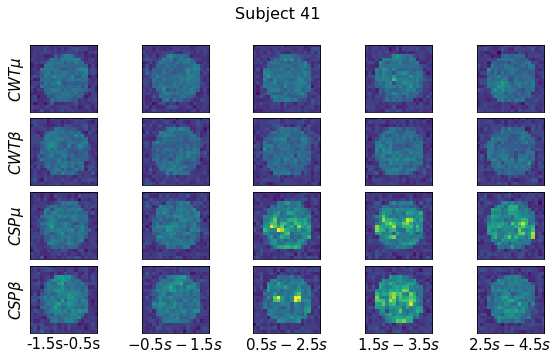

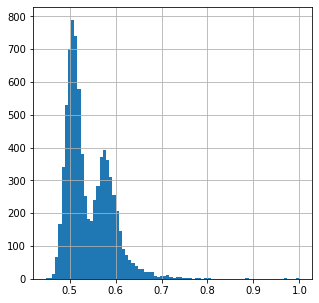

In [11]:
names_x  = [r'-1.5s-0.5s',r'$-0.5s-1.5s$',r'$0.5s-2.5s$',r'$1.5s-3.5s$',r'$2.5s-4.5s$']
Ntw      = 5
n_fb     = 2
Nkfeats  = 2
hist     = []
print('Subject '+str(Nsbj))
# figure plot setting-----------------------------------------------------------
fig, axs = plt.subplots(4,5,figsize=(10,5.3))
fig.subplots_adjust(hspace = 0.1, wspace=.0001)
#-------------------------------------------------------------------------------
# Describe CNN model------------------------------------------------------------
model = cnn_network(n_fb,Nkfeats,Ntw,XF_train_cwt,n_filt,opt_neurons,opt_l1,opt_l2,learning_rate,Nsbj)
#-------------------------------------------------------------------------------
# plot topographic maps---------------------------------------------------------
topo_avg_mu_cwt = []
topo_avg_be_cwt = []
topo_avg_mu_csp = []
topo_avg_be_csp = []
for tw in range(Ntw):
  if tw == 0:
    ids_tw = [tw, tw+1, tw+10, tw+10+1] 
  else:
    ids_tw = [tw*2, tw*2+1, tw*2+10, tw*2+10+1]
  print(ids_tw)
  XT_mu_cwt = []
  XT_be_cwt = []
  XT_mu_csp = []
  XT_be_csp = []
  for fld in range(Nfld):
      filepath        = 'parameter_setting/weights_sbj_'+str(Nsbj)+'_filters_2_units_'+str(int(opt_neurons))+'_lr_0.001_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'.best'+str(fld+1)+'.hdf5'
      checkpoint_path = filepath
      model.load_weights(checkpoint_path)
      # Hidden layer results
      hidden_layer = model.layers[63]
      shape_im     = model.layers[59].output_shape[1:3]
      im_mean      = hidden_layer_results(hidden_layer,shape_im)
      
      # standarsize and normalize-----------------------------
      x_mu_cwt   = np.array(im_mean[ids_tw[0],:,:])
      x_beta_cwt = np.array(im_mean[ids_tw[1],:,:])
      x_mu_csp   = np.array(im_mean[ids_tw[2],:,:])
      x_beta_csp = np.array(im_mean[ids_tw[3],:,:])
      XT_mu_cwt.append(x_mu_cwt)
      XT_be_cwt.append(x_beta_cwt)
      XT_mu_csp.append(x_mu_csp)
      XT_be_csp.append(x_beta_csp)
      #------------------------------------------------------
  
  topo_avg_mu_cwt.append(np.mean(np.array(XT_mu_cwt),axis=0))
  topo_avg_be_cwt.append(np.mean(np.array(XT_be_cwt),axis=0))
  topo_avg_mu_csp.append(np.mean(np.array(XT_mu_csp),axis=0))
  topo_avg_be_csp.append(np.mean(np.array(XT_be_csp),axis=0))

topo_avg_muT_cwt = np.array(topo_avg_mu_cwt)
topo_avg_beT_cwt = np.array(topo_avg_be_cwt)
topo_avg_muT_csp = np.array(topo_avg_mu_csp)
topo_avg_beT_csp = np.array(topo_avg_be_csp)

max_val = max(topo_avg_muT_cwt.max(),topo_avg_beT_cwt.max(),topo_avg_muT_csp.max(),topo_avg_beT_csp.max())
print('max_val',max_val)

topo_avg_muT_cwt = topo_avg_muT_cwt / max_val 
topo_avg_beT_cwt = topo_avg_beT_cwt / max_val 
topo_avg_muT_csp = topo_avg_muT_csp / max_val 
topo_avg_beT_csp = topo_avg_beT_csp / max_val

min_val = min(topo_avg_muT_cwt.min(),topo_avg_beT_cwt.min(),topo_avg_muT_csp.min(),topo_avg_beT_csp.min())
print('min_val',min_val)

for vnt in range(Ntw):
    axs[0,vnt].imshow(topo_avg_muT_cwt[vnt,:,:],vmin=min_val, vmax=0.8)
    axs[1,vnt].imshow(topo_avg_beT_cwt[vnt,:,:],vmin=min_val, vmax=0.8)
    axs[2,vnt].imshow(topo_avg_muT_csp[vnt,:,:],vmin=min_val, vmax=0.8)
    axs[3,vnt].imshow(topo_avg_beT_csp[vnt,:,:],vmin=min_val, vmax=0.8)
    axs[3,vnt].set(xlabel=names_x[vnt])
    axs[3,vnt].xaxis.get_label().set_fontsize(15)
    if vnt == 0:
       axs[0,vnt].set(ylabel=r'$CWT \mu$')
       axs[0,vnt].yaxis.get_label().set_fontsize(15)
       axs[1,vnt].set(ylabel=r'$CWT \beta$')
       axs[1,vnt].yaxis.get_label().set_fontsize(15)
       axs[2,vnt].set(ylabel=r'$CSP \mu$')
       axs[2,vnt].yaxis.get_label().set_fontsize(15)
       axs[3,vnt].set(ylabel=r'$CSP \beta$')
       axs[3,vnt].yaxis.get_label().set_fontsize(15)
    fig.suptitle('Subject '+str(Nsbj), fontsize=16)

    # hist
    hist.append(topo_avg_muT_cwt[vnt,:,:].flatten())
    hist.append(topo_avg_beT_cwt[vnt,:,:].flatten())
    hist.append(topo_avg_muT_csp[vnt,:,:].flatten())
    hist.append(topo_avg_beT_csp[vnt,:,:].flatten())

#---
for ax in axs.flat:
    ax.label_outer()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('results/Topoplots_Subject_'+str(Nsbj)+'T.eps', format='eps')
#---

#plot histograms
hist = np.concatenate(hist)
hist = hist.flatten()
plt.figure(figsize=(5,5))
plt.hist(hist,bins=80)
plt.grid()


**NOTE:**
- The files of optimal model, the performance file, and the figures can be downloaded from current session COLAB.